In [32]:
import sys

In [33]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression


In [34]:
ameriflux = pd.read_csv('freq_anual/AMF_PE-QFR_FLUXNET_FULLSET_YY_2018-2019_3-5.csv',na_values=-9999) # Dados da AMERIFLUX
modis = pd.read_csv('freq_anual/Npp_500m.csv',header=None)
ameriflux[['GPP_DT_VUT_MEAN','NEE_VUT_MEAN','RECO_DT_VUT_MEAN']]

,GPP_DT_VUT_MEAN,NEE_VUT_MEAN,RECO_DT_VUT_MEAN
0,3462.21,-568.817,3095.56
1,3326.45,-481.231,2999.45


In [35]:
npp = (ameriflux['GPP_DT_VUT_MEAN'] - ameriflux['RECO_DT_VUT_MEAN'])/1000  # NPP do Ameriflux gerado pela média do RECO (DURANTE O DIA) + NEE e convertido de gC m−2 y−1 para kgC/m²/year divindo o valor por 1000
npp # NPP calculado                                                         # OBS1: RECO_DT = Partitioning NEE using the daytime flux method, Lasslop et al. (2010)
                                                                            # OBS2: _VUT_ = Variable USTAR threshold for each year
                                                                            # OBS3: _MEAN = Average NEE after filtering using multiple USTAR thresholds;

0    0.36665
1    0.32700
dtype: float64

In [36]:
def modis_npp(modis_data):
    modis_data = modis_data.loc[modis[2].isin(['A2018001','A2019001'])].copy() # Dados de NPP nos anos de 2009, 2010 e 2011
    modis_data = modis_data.drop([0,1,3,4],axis=1).reset_index().drop('index',axis=1) # Retirando colunas com informações não relevantes e restabelecendo o dataframe a partir de um index 0 nas 2 linhas
    modis_data.columns = range(len(modis_data.columns.to_list())) # Reiniciando o index a partir do 0 para as colunas 
    modis_data.set_index(0,inplace=True) # Colocando o "Acquisition Date [ A (YYYYDDD) ]"  como index para legibilidade do dataframe
    modis_npp_mean = modis_data.apply(lambda x:x/10000).mean(axis=1) # Média de NPP nesses anos 
    return modis_npp_mean

modis_npp_mean = modis_npp(modis)

In [37]:
modis_npp_mean_values = modis_npp_mean.values # valores do npp do modis
ameriflux_npp_values = npp.values #valores do npp do ameriflux

ameriflux['npp'] = ameriflux_npp_values
ameriflux['npp_modis'] = modis_npp_mean_values

npp_dataframe = {
    'modis_NPP':modis_npp_mean_values,
    'ameriflux_NPP':ameriflux_npp_values
}

npp_dataframe = pd.DataFrame(npp_dataframe) # dataframe com os valores do npp
npp_dataframe

,modis_NPP,ameriflux_NPP
0,1.172167,0.36665
1,1.078046,0.32700


In [38]:
# FUNÇÃO CRIADA PARA CRIAÇÃO DOS GRÁFICOS

def reg_graph (x, y, data,sct_size=None,s=10,title='', legend_visibility=True, legend_title='', xlabel='', ylabel='', fit_intercept=True, ativar_grafico_yx=False,reg_from_start=False, offset_txt_x=0.15,offset_txt_y=2.25):
    # x = eixo x do gráfico
    # y = eixo y do gráfico
    # data = dataframe origem dos dados que representam x e y
    # sct_size = tamanho do scatter no gráfico BASEADO em uma coluna do dataframe
    # s = tamanho do scatter no gráfico BASEADO em um NUMERO
    # title = título do gráfico
    # legend_visibility = visibilidade da legenda
    # legend_title = título da legenda
    # xlabel = título do eixo x
    # ylabel = titulo do eixo y
    # offset_txt_x = deslocamento do texto da função no eixo x
    # offset_txt_y = deslocamento do texto da função no eixo y
    
    sns.set_style('darkgrid')
    
    f, ax = plt.subplots(1,figsize=(8, 5))
    
    sns.scatterplot(x=data[x], y=data[y], data=data,size=sct_size,s=s)
    
    rng = np.random.default_rng(1234) #seed para valores aleatórios
    lr = LinearRegression(fit_intercept=fit_intercept)   
    fitted_reg = lr.fit(data[[x]],data[[y]])
    
    if not fit_intercept:
        fitted_reg.intercept_ = [fitted_reg.intercept_] # Prevenindo erros
        
    r2_score = fitted_reg.score(data[[x]],data[[y]]) # R² Score
    x_reg_line = rng.uniform(data[x].min(), data[x].max(), size=100) # gerando valores entre os valores do scatterplot para criar a reta
    y_reg_line = x_reg_line * fitted_reg.coef_ + fitted_reg.intercept_[0] # função y=ax + b para representar a reta criada
    
    if reg_from_start:
        
        if (data[x].min() < 0) and (abs(data[x].min()) > data[y].max()): # Para valores data[x] negativos
            
            x_reg_line = rng.uniform(data[x].min() * 2 , 0, size=1000) # gerando valores entre os valores do scatterplot para criar a reta, partindo do 0
            
        elif (data[y].min() < 0) and (abs(data[y].min()) > data[x].max()): # Para valores data[y] negativos

            x_reg_line = rng.uniform(data[y].min() * 2 , 0, size=1000) # gerando valores entre os valores do scatterplot para criar a reta, partindo do 0
            
        elif (data[x].max() > data[y].max()):
              
            x_reg_line = rng.uniform(0, data[x].max() * 2, size=1000)
              
        else:
              
            x_reg_line = rng.uniform(0, data[y].max() * 2, size=1000)
              
        y_reg_line = x_reg_line * fitted_reg.coef_ + fitted_reg.intercept_[0] # função y=ax + b para representar a reta criada

    
    text_coord_x = data[x].max() - data[x].max() * offset_txt_x  #eixo x do texto

    
    plt.text(text_coord_x, offset_txt_y, f'Y={round(fitted_reg.coef_[0][0],4)}x + {round(fitted_reg.intercept_[0],4)}',fontsize=12, ha='center', va='center',color='blue') #Texto da reta Azul
    plt.text(text_coord_x, offset_txt_y - (offset_txt_y*0.3), f'R²:{round(r2_score,4)}', fontsize=12, ha='center', va='center',color='blue') # Texto r²
    

    ax.set_ylim((0, (data[y].max() + (data[y].max()/2)))) # tamanho limite do plot no eixo y
    ax.set_xlim((0, data[x].max() + data[x].max()/2)) # tamanho limite do plot no eixo x
    ax.plot(x_reg_line,y_reg_line[0]) #reta de regressão

    if ativar_grafico_yx:
        y_x = rng.uniform(0, 1000, size=1000) # gerando 100 valores aleatórios 
        ax.plot(y_x,y_x, 'k--') # reta y=x
    
    if legend_title:
        plt.legend(title=legend_title,loc='upper left').set_visible(legend_visibility) #legenda no canto superior esquerdo
    
    plt.title(title) # Título do gráfico
    plt.xlabel(xlabel) #Título do eixo X
    plt.ylabel(ylabel) #Título do eixo y
    plt.tight_layout() #Redimensionar melhor o gráfico
    plt.show() #Mostrar o gráfico

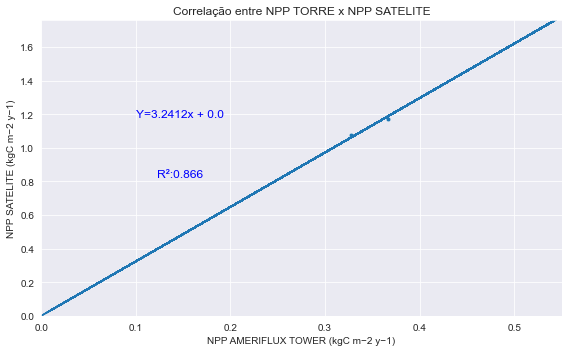

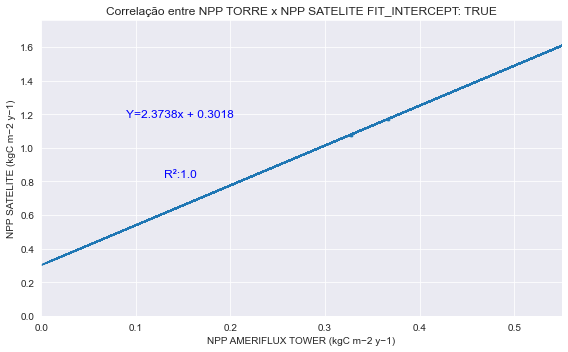

In [39]:
eixo_x = 'ameriflux_NPP'
eixo_y = 'modis_NPP'
data = npp_dataframe
xlabel = "NPP AMERIFLUX TOWER (kgC m−2 y−1)"
ylabel = "NPP SATELITE (kgC m−2 y−1)"
title = "Correlação entre NPP TORRE x NPP SATELITE"

reg_graph(eixo_x,eixo_y,data=data,s=20,xlabel=xlabel,ylabel=ylabel,title=title,legend_visibility=False,fit_intercept=False,ativar_grafico_yx=True,reg_from_start=True, offset_txt_x=0.6,offset_txt_y=1.2)
reg_graph(eixo_x,eixo_y,data=data,s=20,xlabel=xlabel,ylabel=ylabel,title=title + ' FIT_INTERCEPT: TRUE',legend_visibility=False,ativar_grafico_yx=True,reg_from_start=True, offset_txt_x=0.6,offset_txt_y=1.2)
# Com o fit intercept no true, o r² dá 1.0

In [40]:
#================================================================================================================================================#
    ##  GRAFICOS GERADOS COM BASE NO NPP CALCULADO ATRAVES DO GPP - RECO ##

In [41]:
ameriflux_mensal = pd.read_csv('freq_mensal/AMF_PE-QFR_FLUXNET_FULLSET_MM_2018-2019_3-5.csv',na_values=-9999)
ameriflux_mensal['NPP'] = (ameriflux_mensal['GPP_DT_VUT_MEAN'] - ameriflux_mensal['RECO_DT_VUT_MEAN'])   #OBS: NPP = gC m−2  d−1
npp = ameriflux_mensal['NPP']

Text(0, 0.5, 'NPP')

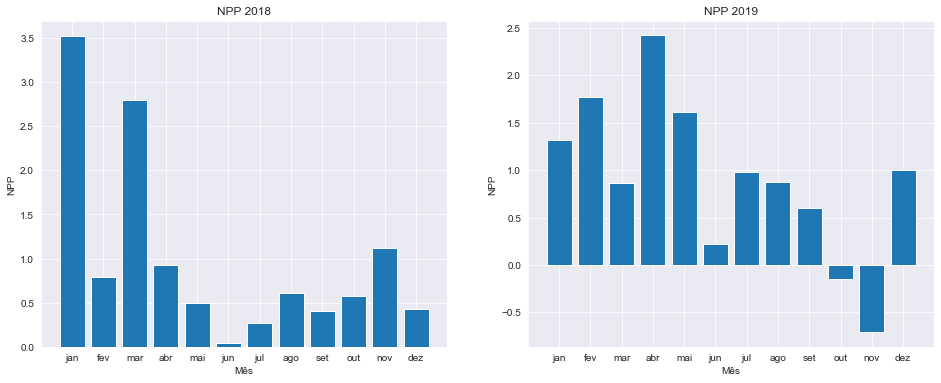

In [42]:
meses_abreviados = ["jan", "fev", "mar", "abr", "mai", "jun", "jul", "ago", "set", "out", "nov", "dez"]

df = pd.DataFrame({"Meses": meses_abreviados, "NPP": npp[0:12]}) # NPP 2018
df2 = pd.DataFrame({"Meses": meses_abreviados, "NPP": npp[12:]}) # NPP 2019


fig, axs = plt.subplots(1, 2, figsize=(16, 6))

axs[0].bar(df["Meses"], df["NPP"])
axs[0].set_title("NPP 2018")
axs[0].set_xlabel("Mês")
axs[0].set_ylabel("NPP")


axs[1].bar(df2["Meses"], df2["NPP"])
axs[1].set_title("NPP 2019")
axs[1].set_xlabel("Mês")
axs[1].set_ylabel("NPP")

In [43]:
# Artigo Fonte:
# https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4971002/

#There are multiple researches analyzing the impact factors of NPP,
#such as precipitation, temperature and atmospheric carbon dioxide concentration (Melton et al. 2013).
#Some researchers conclude that soil moisture is the dominant factor controlling NPP compared with annual rainfall (Raich et al. 1991).
#NPP of arid ecosystem is mostly influenced by water, by enhancing the water use efficiency of vegetation (Xiao et al. 1995). 
#For areas with limited temperature, NPP will get larger when temperature becomes higher (Nemani et al. 2003; Lucht et al. 2002; Bogaert et al. 2002; Piao et al. 2006). 
#In terms of tropical areas, solar radiation becomes the dominant factor in influencing NPP because of severe cloudiness (Zhao and Running 2010; Garbulsky et al. 2010). 
#The annual NPP is strongly correlated with the mean annual precipitation and temperature in dry and cold areas (Zhu and Southworth 2013; Schuur 2003). 
#Moreover, there are also several studies suggesting a significant correlation relationship between normalized difference vegetation index (NDVI) and NPP (Paruelo et al. 1997; Fensholt et al. 2013).
#NDVI, as a difference ratio of near infra-red and red reflectance values, is commonly used to monitor vegetation growth status and the vegetation coverage.


#For global NPP, different climatic characteristics of different types of land are influenced by different variables.
#Generally, the land types cover forest, water, shrub lands, cropland, permanent wetland, grassland, built-up areas and snow cover.
#In terms of NPP in different types of land, there have been many researches analyzing the impact factors of NPP in each land type. 
#Climate variables such as temperature, precipitation, topography and soil type have been validated to have strong correlation relationship with the NPP in forest (Whittaker 1970; Woodward et al. 2004; Holdridge 1964; Pan et al. 2013),
#savanna (Zhu and Southworth 2013; Schuur 2003), grassland (Scholes and Hall 1996; Xia et al. 2014) and wetland (Birkett 1998). 
#The impact of anthropogenic activities in CO2 emissions and land cover change on NPP analyzed in studies (Prentice et al. 2001; Ou et al. 2015; Haberl et al. 2007) has turned out to be pervasive and serious.


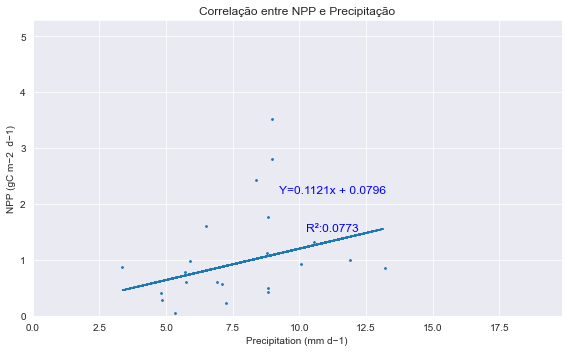

In [44]:
# Artigos fonte
# https://www.mdpi.com/1999-4907/13/9/1367

##### MOTIVO DA UTILIZAÇÃO DA PRECIPITAÇÃO NA CORRELAÇÃO

# Precipitations is one of the main climatic factors driving changes in the NPP.
# NPP can be promoted in the vegetation growth period and in arid areas, 
# as seen in the drought from 2009 to 2010. 
# However, the southwest karst region is located in the subtropical monsoon region. 
# Although the rainfall (1000–2000 mm) is relatively low, 
# the water stress effect caused by engineering water shortages caused by karst landforms 
# and their impact on the NPP are very worthy of attention and research.


eixo_x = 'P_ERA' # Precipitation Data filled by using ERA5 downscaling
eixo_y = 'NPP'

reg_graph(eixo_x,eixo_y,ameriflux_mensal,title="Correlação entre NPP e Precipitação",legend_visibility=False,xlabel='Precipitation (mm d−1)',ylabel="NPP (gC m−2  d−1)")

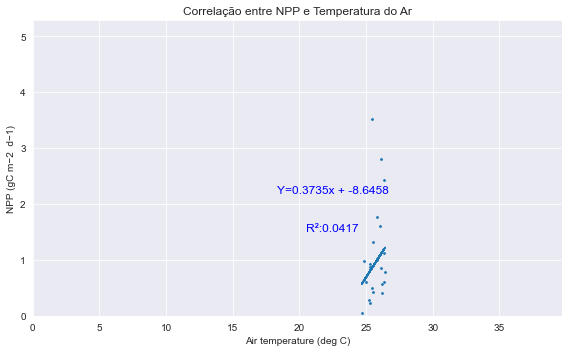

In [45]:
# Artigos fonte
# https://www.mdpi.com/1999-4907/13/9/1367

#### MOTIVO DA UTILIZAÇÃO DA TEMPERATURA (NESSE CASO, DO AR) NA CORRELAÇÃO

# Temperature is one of the main climatic factors driving changes in the NPP,
# with obvious seasonal variation. In high latitudes, vegetation growth is periodic,
# and in humid and semi-humid areas, temperature promotes NPP growth by promoting photosynthesis of vegetation and the release of nutrients in soil.
# When the temperature is too high, it aggravates the transpiration of vegetation and decreases the NPP.

eixo_x = 'TA_ERA'
eixo_y = 'NPP'
reg_graph(eixo_x,eixo_y,ameriflux_mensal,title="Correlação entre NPP e Temperatura do Ar",xlabel='Air temperature (deg C)',ylabel="NPP (gC m−2  d−1)",legend_visibility=False)

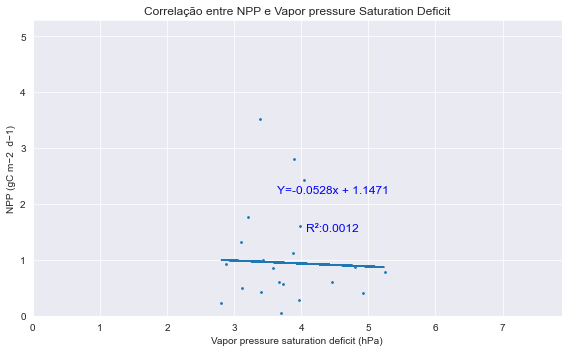

In [46]:
# Artigos fonte
# https://www.mdpi.com/1999-4907/13/9/1367

### MOTIVO DA UTILIZAÇÃO DO VAPOR PRESSURE DEFICIT
# In summary, from the perspective of a single climate factor, the relationship between NPP changes in forest vegetation and temperature in karst areas of southwest China is mainly positive, 
# the relationship with precipitation is complex and the relationship with VPD is negative.
# However, generally, temperature, precipitation and VPD affect NPP changes together, and the impact on the NPP also has a certain seasonality and lag. 
# In humid and semi-humid areas, temperature is the dominant factor, and precipitation is the dominant factor in arid, semi-arid and engineering water shortage areas. 
# In dry and hot seasons, temperature and precipitation affect the VPD and NPP. 
# In addition, the response of forest vegetation NPP to climate is also affected by topographic factors [74].
# For example, in high-altitude areas, due to the particularity of karst landforms, precipitation increases soil erosion, thus reducing vegetation NPP;
# water and soil loss is not easy in low-altitude areas, and precipitation promotes the increase in NPP.


eixo_x = 'VPD_ERA' # Vapor pressure saturation deficit Data filled by using ERA5 downscaling
eixo_y = 'NPP'
dataframe = ameriflux_mensal
title= "Correlação entre NPP e Vapor pressure Saturation Deficit"
xlabel = 'Vapor pressure saturation deficit (hPa)'
ylabel = "NPP (gC m−2  d−1)"

reg_graph(eixo_x, eixo_y, data=dataframe, title=title, xlabel=xlabel, ylabel=ylabel, legend_visibility=False)